# Forecast

In [1]:
from sklearn.model_selection import train_test_split
import pyaiutils as pai
import pandas as pd

In [2]:
DATA_DIR = './downloads/pre-processed'

In [3]:
from tensorflow.keras import backend as K


class Metric:
    """Class with the metrics to evaluate the forecast
    """

    @staticmethod
    def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    @staticmethod
    def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    
    @staticmethod
    def f1_m(y_true, y_pred):
        precision = precision_m(y_true, y_pred)
        recall = recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
import tensorflow as tf
import numpy as np
import sklearn
import pickle


class Model:
    
    def __init__(self, model: str, scaler: str):
        """Class for the neural network model.
        
        Parameters
        ----------
        model : str
            Path to the model file
        scaler : str
            Path to the scaler file
        """
        self._model = self._load_model(model)
        self._scaler = self._load_scaler(scaler)
        
    def _load_model(self, path: str) -> tf.keras.Model:
        """Load the model
        
        Parameters
        ----------
        path : str
            Path to the model file

        Returns
        -------
        tf.keras.Model
            Keras model
        """
        try:
            return tf.keras.models.load_model(
                path,
                custom_objects = {
                    'precision_m': Metric.precision_m,
                    'recall_m': Metric.recall_m,
                    'f1_m': Metric.f1_m
                }
            )
        except OSError:
            raise OSError(f'Model not found in {path}')
    
    def _load_scaler(self, path: str):
        """Load the scaler
        
        Parameters
        ----------
        path : str
            Path to the scaler file

        Returns
        -------
        sklearn.preprocessing.*
            Scikit-learn scaler
        """
        try:
            with open(path, 'rb') as f:
                return pickle.load(f)
        except FileNotFoundError:
            raise FileNotFoundError(f'Scaler not found in {path}')
        
    def _transform(self) -> None:
        """Abstract method
        """
        raise NotImplementedError

    def predict(self, x: np.ndarray):
        """Predict from x
        
        Parameters
        ----------
        x : np.ndarray
            Array expected for model entry

        Returns
        -------
        np.ndarray
            x forecast result
        """
        return self._model.predict(self._transform(x))
    
    def evaluate(
        self,
        x_test: np.ndarray,
        y_test: np.ndarray,
        class_names: [str],
        path: str = None
    ) -> np.ndarray:
        y_pred = self.predict(x_test)
        y_true = np.argmax(y_test, axis=1)
        y_pred = np.argmax(y_pred, axis=1)
        pai.plot_graphics(y_true, y_pred, class_names=class_names, save_path=path)
        display(pai.get_metrics(y_true, y_pred, class_names=class_names, save_path=path))

In [5]:
class MLP(Model):
    def _transform(self, x: np.ndarray) -> np.ndarray:
        """x scale
        
        Parameters
        ----------
        x : np.ndarray
            Array expected for model entry

        Returns
        -------
        np.ndarray
            x scaled
        """
        return self._scaler.transform(x)

In [6]:
class CNN(Model):
    def _transform(self, x: np.ndarray) -> np.ndarray:
        """x scale
        
        Parameters
        ----------
        x : np.ndarray
            Array expected for model entry

        Returns
        -------
        np.ndarray
            x scaled
        """
        x = self._scaler.transform(x)
        return np.reshape(x, (x.shape[0], 1, x.shape[1]))
         

In [7]:
def replace(df: pd.DataFrame, rules: {}) -> pd.DataFrame:    
    for rule in rules.values():
        cols = rule['cols']
        df[cols] = df[cols].replace(rule['replaces'], regex=rule['regex'])
    return df

### Examples

COVID/NÃO-COVID

Expected entries for the model (In expected order)

In [14]:
# 'Apresentou perda de olfato e/ou paladar?',
# 'Apresentou cefaléia?',
# 'Apresentou adinamia?',
# 'Apresentou dores musculares e/ou nas articulações?',
# 'Apresentou calafrios?',
# 'Apresentou tontura?',
# 'Apresentou sudorese noturna?',
# 'Apresentou irritabilidade/confusão?',
# 'Possui neoplasia (tumor sólido ou hematológico)?',
# 'Possui doença respiratória crônica?',
# 'Gestante?',
# 'Desfecho (cura/óbito)'
symptoms = [
    'Apresentou febre?', # Febre
    'Apresentou tosse?', # Tosse
    'Apresentou dor de garganta?', # Dor de garganta
    'Apresentou dispneia?', # Dispneia // falta de ar
    'Apresentou desconforto respiratório?', # Desconforto respiratório
#     'Saturação de Oxigênio abaixo de 95%?', # Saturação de O2 abaixo de 95%
    'Apresentou diarreia?', # Diarreia
#     'Apresentou náusea/vômito?', # Vômito
]
comorbidities = [
#     'É puérpera?', # Puérpera // mulher que deu à luz há bem pouco tempo.
    'Possui doença cardiovascular?', # Doença cardiovascular // coração
#     'Possui doença hematológica?', # Componentes do sangue
#     'Portador de alteração cromossômica?', # Síndrome de Down
#     'Possui doença hepática?', # Doença hepática // fígado
#     'ASMA', # Asma
#     'Possui diabetes mellitus?', Diabetes
#     'Possui doença neurológica?', # Doença neurológica // sistema nervoso
    'Possui pneumopatia?', # Pneumopatia // pulmão
    'Possui imunodeficiência ou imunodepressão?', # Imunodeficiência ou Imunodepressão // sistema imunológico
    'Possui doença renal?', # Doença renal
#     'Possui obesidade?', # Obesidade
]
x_cols = [
    *symptoms,
    *comorbidities,
#     'Sexo', # Sexo
    'Idade em anos', # Idade
]
y_cols = ['Classificado como COVID-19?'] # Classificação

|Sintomas|Comorbidades|CS_SEXO|NU_IDADE_N|CLASSI_FIN|
|--|--|--|--|--|
|0. NaN|0. NaN|||
|1. Sim|1. Sim|1: Masculino||0. Não Covid|
|2. Não|2. Não|2: Feminino||1. Covid|
|9. Ignorado|9. Ignorado||||

Open dataset

In [16]:
df = pd.read_excel(f'{DATA_DIR}/Mapping_RT-PCR_Final_11.02.2021.xlsx')
df = df[[*x_cols, *y_cols]]
df

,Apresentou febre?,Apresentou tosse?,Apresentou dor de garganta?,Apresentou dispneia?,Apresentou desconforto respiratório?,Apresentou diarreia?,Possui doença cardiovascular?,Portador de alteração cromossômica?,Possui doença hepática?,Possui doença neurológica?,Possui pneumopatia?,Possui imunodeficiência ou imunodepressão?,Possui doença renal?,Possui obesidade?,Sexo,Idade em anos,Classificado como COVID-19?
0,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,M,54.0,NÃO
1,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,M,34.0,NÃO
2,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,M,36.0,NÃO
3,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,M,59.0,NÃO
4,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,F,23.0,NÃO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11000,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,SIM,NÃO,M,40.0,NÃO
11001,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,M,23.0,NÃO
11002,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,M,23.0,NÃO
11003,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,M,27.0,NÃO


Mapping attributes expected by the model

In [17]:
rules = {
    0: {
        'cols': [*symptoms, *comorbidities],
        'replaces': {r'^SIM': 1, r'^NÃO': 2, r'^S/I': 0},
        'regex': True
    },
    1: {
        'cols': 'Sexo',
        'replaces': {r'^M': 1, r'^F': 2},
        'regex': True
    },
    2: {
        'cols': 'Classificado como COVID-19?',
        'replaces': {r'^SIM': 1, r'^NÃO': 0, r'^REPETIR': np.nan, r'^INCONCLUSIVO': np.nan},
        'regex': True
    }
}

In [18]:
df = replace(df, rules)
df = df[~df.isnull().any(axis=1)]
df

,Apresentou febre?,Apresentou tosse?,Apresentou dor de garganta?,Apresentou dispneia?,Apresentou desconforto respiratório?,Apresentou diarreia?,Possui doença cardiovascular?,Portador de alteração cromossômica?,Possui doença hepática?,Possui doença neurológica?,Possui pneumopatia?,Possui imunodeficiência ou imunodepressão?,Possui doença renal?,Possui obesidade?,Sexo,Idade em anos,Classificado como COVID-19?
0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1.0,54.0,0.0
1,2,1,2,2,2,2,2,2,2,2,2,2,2,2,1.0,34.0,0.0
2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1.0,36.0,0.0
3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1.0,59.0,0.0
4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2.0,23.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11000,2,2,2,2,2,2,2,2,2,2,2,2,1,2,1.0,40.0,0.0
11001,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1.0,23.0,0.0
11002,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1.0,23.0,0.0
11003,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1.0,27.0,0.0


In [14]:
test = df.copy()

Get non-covid data for training

In [16]:
ncovid = df[df['Classificado como COVID-19?'] == 0]
covid = df[df['Classificado como COVID-19?'] == 1.0]

In [56]:
train, test = train_test_split(ncovid, test_size=0.0788)

In [62]:
train.to_csv(f'{DATA_DIR}/ISI/train_data/train_11.02.2021.csv', index=False)

In [19]:
test = pd.concat([test,covid])
test.to_csv(f'{DATA_DIR}/ISI/test_data/test_11.02.2021.csv', index=False)

Get only covid cases

In [60]:
# df = df[df['Classificado como COVID-19?'] == 1]
# df.shape

Save x,y

In [20]:
test[x_cols].to_csv(f'{DATA_DIR}/ISI/test_data/test_11.02.2021-xcols.csv', index=False)
test[y_cols].to_csv(f'{DATA_DIR}/ISI/test_data/test_11.02.2021-ycols.csv', index=False)

In [9]:
test = pd.read_csv(f'{DATA_DIR}/ISI/test_data/test_11.02.2021.csv', low_memory=False)
test

,Apresentou febre?,Apresentou tosse?,Apresentou dor de garganta?,Apresentou dispneia?,Apresentou desconforto respiratório?,Saturação de Oxigênio abaixo de 95%?,Apresentou diarreia?,É puérpera?,Possui doença cardiovascular?,Portador de alteração cromossômica?,Possui doença hepática?,Possui doença neurológica?,Possui pneumopatia?,Possui imunodeficiência ou imunodepressão?,Possui doença renal?,Possui obesidade?,Sexo,Idade em anos,Classificado como COVID-19?
0,2,2,2,2,2,0,2,0,2,2,2,2,2,2,2,2,1.0,31.0,0.0
1,2,2,2,2,2,0,2,0,2,2,2,2,2,2,2,2,1.0,42.0,0.0
2,2,2,2,2,2,0,2,0,2,2,2,2,2,2,2,2,1.0,28.0,0.0
3,2,2,2,2,2,0,2,0,2,2,2,2,2,2,2,2,1.0,27.0,0.0
4,2,2,2,2,2,0,2,0,2,2,2,2,2,2,2,2,1.0,38.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,2,2,2,2,2,0,2,0,1,2,2,2,2,2,2,2,1.0,47.0,1.0
1530,1,1,1,2,2,0,2,0,1,2,2,2,2,2,2,2,1.0,37.0,1.0
1531,1,1,2,2,2,0,2,0,2,2,2,2,2,2,2,2,1.0,24.0,1.0
1532,2,2,2,2,2,0,2,0,1,2,2,2,2,2,2,2,2.0,46.0,1.0


Removendo features (alternativa)

In [10]:
test = test.drop(
    columns=[
        'Saturação de Oxigênio abaixo de 95%?',
        'É puérpera?',
        'Portador de alteração cromossômica?',
        'Possui doença hepática?',
        'Possui doença neurológica?',
        'Possui obesidade?',
        'Sexo'
    ]
)
test

,Apresentou febre?,Apresentou tosse?,Apresentou dor de garganta?,Apresentou dispneia?,Apresentou desconforto respiratório?,Apresentou diarreia?,Possui doença cardiovascular?,Possui pneumopatia?,Possui imunodeficiência ou imunodepressão?,Possui doença renal?,Idade em anos,Classificado como COVID-19?
0,2,2,2,2,2,2,2,2,2,2,31.0,0.0
1,2,2,2,2,2,2,2,2,2,2,42.0,0.0
2,2,2,2,2,2,2,2,2,2,2,28.0,0.0
3,2,2,2,2,2,2,2,2,2,2,27.0,0.0
4,2,2,2,2,2,2,2,2,2,2,38.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1529,2,2,2,2,2,2,1,2,2,2,47.0,1.0
1530,1,1,1,2,2,2,1,2,2,2,37.0,1.0
1531,1,1,2,2,2,2,2,2,2,2,24.0,1.0
1532,2,2,2,2,2,2,1,2,2,2,46.0,1.0


- pm: path to the model
- ps: path to the scaler

In [11]:
# pm = './models/mlp_covid.h5'
# ps = './scalers/scaler_covid.pkl'
# covid = MLP(model=pm, scaler=ps)

# pm = './models/cnn_covid.h5'
# ps = './scalers/scaler_covid.pkl'

# pm = './downloads/results/ALL/covid-ncovid/cnn/deploy/model.h5'
# ps = './downloads/results/ALL/covid-ncovid/cnn/deploy/xscaler.pkl'

# pm = './downloads/results/ALL/covid-ncovid/mlp/r_saturacao_puerpera/best_model.h5'
# ps = './downloads/pre-processed/ALL/covid-ncovid/mlp/r_saturacao_puerpera/xscaler.pkl'

pm = './downloads/results/ALL/covid-ncovid/mlp/r_per_sat_down_hep_neu_obe_sex/deploy/model.h5'
ps = './downloads/results/ALL/covid-ncovid/mlp/r_per_sat_down_hep_neu_obe_sex/deploy/xscaler.pkl'

covid = MLP(model=pm, scaler=ps)

Prediction

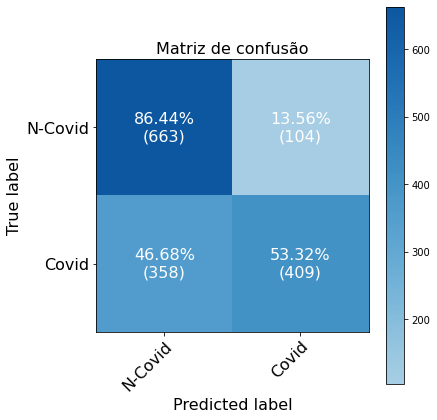

None

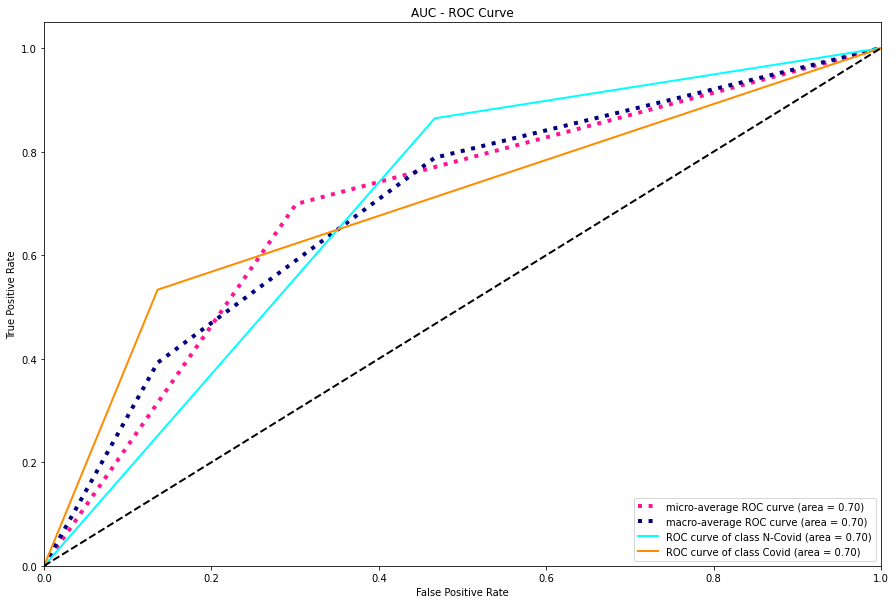

None

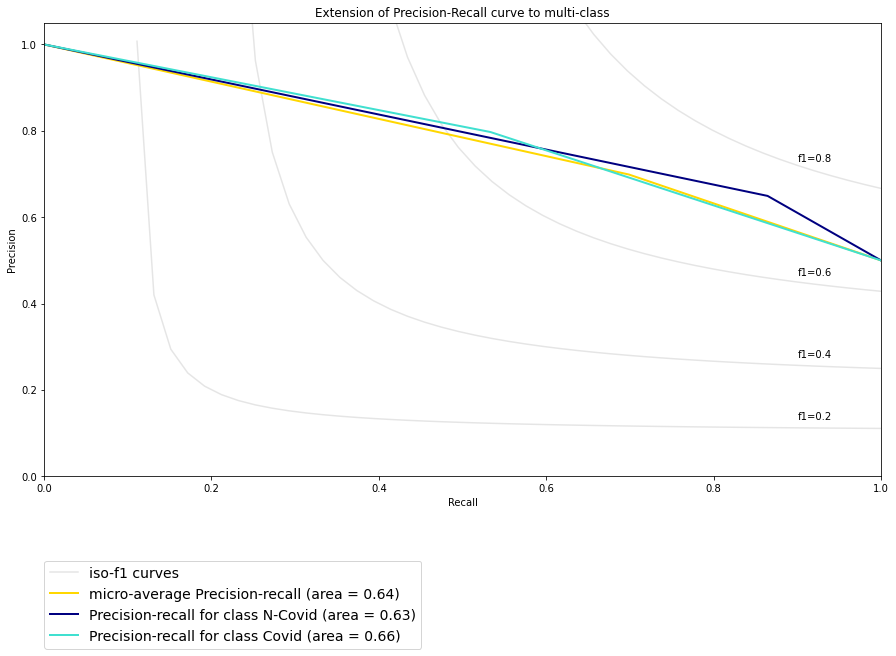

None

,Classes,F1,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
0,N-Covid,0.74,0.7,0.63,0.65,0.86,0.53,0.7
1,Covid,0.64,0.7,0.66,0.80,0.53,0.86,0.7
2,Média,0.69,0.7,0.64,0.73,0.70,0.70,0.7


In [15]:
covid.evaluate(
    x_test=test[x_cols],
    y_test=tf.keras.utils.to_categorical(test[y_cols]),
    class_names=['N-Covid', 'Covid'],
    path='./downloads/results/ISI/alldatas/r_per_sat_down_hep_neu_obe_sex'
)